In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')
#sys.path.insert(0, '/home/mahdik/workspace/mavenn/')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
data_df = pd.read_csv('data/ARS_data/exp_6_mpathic.csv')
data_df = data_df[['ars','ct_x','ct_y']].copy()
data_df.head()

,ars,ct_x,ct_y
0,CCGGTTTGATTTTTTAAGTCATAATTGAATACCTGAATATGAAAAA...,5.0,0.0
1,AATGGTTGATTTGTTAAATCGCAATTTAAGCCCTACATATAAAAAA...,4.0,0.0
2,AGTGTTTGATTTTTTAAACCGCAATTTAGTACCTAAATGTAAAAAA...,4.0,0.0
3,AATGTATGGTTTTTTCAGTCGCAATTAAATATCTATCTATAGATTA...,4.0,0.0
4,AATGTTCGATTTTTATAATCGCAATCTAATAACCAAATGTAACTAA...,4.0,0.0


In [3]:
y_cols = data_df.columns[1:]

X = data_df['ars']
y = data_df[y_cols]

In [4]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
# set positional argumnets for gpmap function
L = len(data_df['ars'][0])
alphabet=['A','C','G','T']

Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=149, Y=2


In [6]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)


2022-05-13 13:39:23.502461: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create measurement process object(s)

In [7]:
mp_EE = mavenn.measurement_process_layers.ExponentialEnrichmentMP(Y=Y,
                                                                  t_y=[0,1],
                                                                  eta=1e-5,
                                                                  info_for_layers_dict={'H_y_norm':0})


In [8]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_EE])

In [9]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 598)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 596)          0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           597         ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [10]:
# #*np.ones(shape=y_list[0].shape[0])

# y_cts_df = pd.DataFrame(np.random.rand(y_list[0].shape[0]))
# y_cts_df.head()

In [11]:
# y_dict = {}

# y_list=[data_df[y_cols].values]
# #y_dict[output_layer_index] = current_y_norm
# y_discrete_df = pd.DataFrame(y_list[0])
# y_discrete_df.head()

In [12]:
# Set training data
model.set_data(x=x_train,
               y_list = [y_train[y_cols].values],
               shuffle=False)

N = 170,652 observations set as training data.
Using 20.1% for validation.
Time to set data: 6.97 sec.


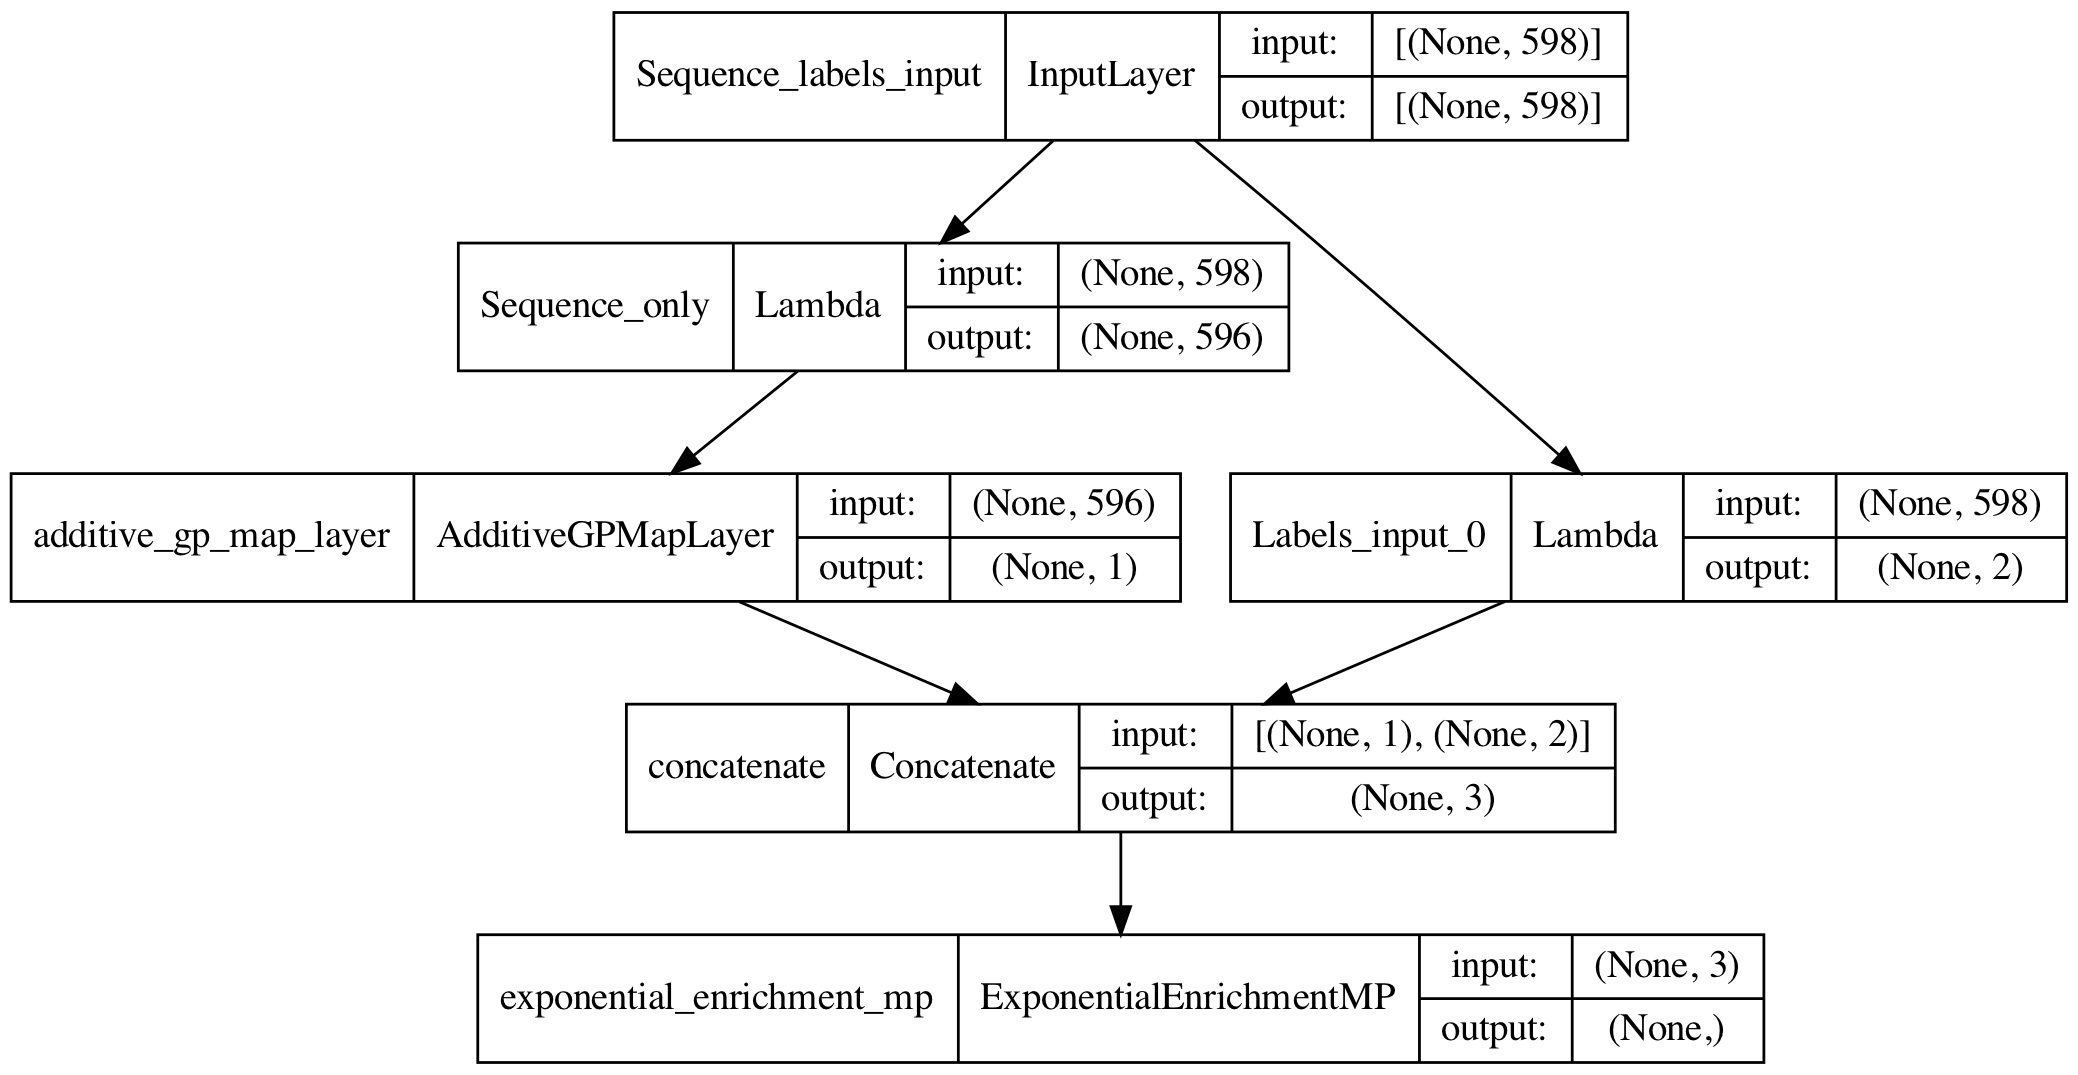

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=200)

In [14]:

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=1000,
          batch_size=200,
          verbose= False, 
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  4%|▉                     | 41/1000 [01:01<23:50,  1.49s/epoch, loss=119, I_var=0.532, val_loss=126, val_I_var=0.5]

Training time: 62.6 seconds


On test data:


Text(0.5, 1.0, 'training hisotry')

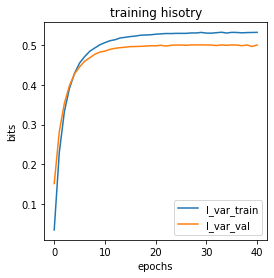

In [15]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

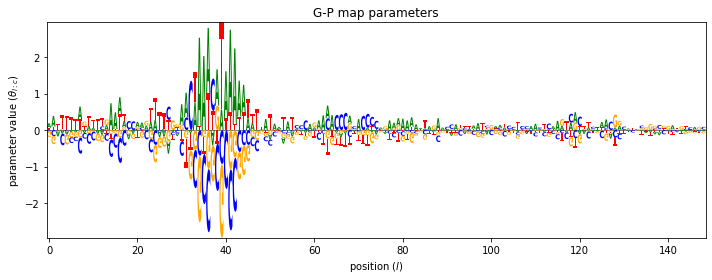

In [16]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_EE.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[10,4])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
#fig.savefig('sortseq_g-p_map_mpa_visualization.png')
plt.show()

In [17]:
phi = gpmap.x_to_phi(x_test)

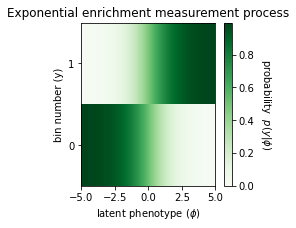

In [18]:
# Create grid in phi space
phi_lim = [-5, 5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_EE.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = mp_EE.p_of_y_given_phi(y_all, phi_grid)


# Create figure with two panels
fig, ax = plt.subplots(1,1,figsize=[3,3])

# Right panel: draw measurement process as heatmap
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('Exponential enrichment measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
